# Beta-Gamma reparameterization for IKLP priors $(s,p,\kappa)$

Yoshii & Goto (2013) prior $p(z)$ for the signal and noise power scales exert important control to whether VI finds explanation of (signal + plausible filter) rather than (noise + very intricately shaped filter).
They give these as two Gamma(1, 1) = Exp(1) priors.
However we reparametrize these two independent gammas by **sum** and **ratio** variables and control the prior with three knobs $(s,p,\kappa)$ rather than $(a_w, b_w, a_e, b_e)$ to have an easier way to guide to VI to what we know.

Original paper prior (Yoshii & Goto, 2013):

$$

 \nu_w \sim \mathrm{Gamma}(a_w,b_w),\quad

 \nu_e \sim \mathrm{Gamma}(a_e,b_e),


$$

with the baseline $a_w=a_e=b_w=b_e=1$ (so $\mathbb{E}[\nu_w+\nu_e]=2$ rather than 1 (unit power)!).

Our reparameterization: the variables whose expectation values we know most about _a priori_:

$$

 \text{Total power }S:=\nu_w+\nu_e,\quad\text{Degree of periodicity (pitchedness) } \pi:=\frac{\nu_w}{\nu_w+\nu_e}\in(0,1),


$$

where $S \sim\mathrm{Gamma}(a_w+a_e, b)$ and $\pi \sim\mathrm{Beta}(a_w, a_e)$ where $b = b_w = b_e$ is assumed (if they differ, no such neat induced distributions).

We then set their hyperparameters in terms of our 3 knobs: expected pitchness $p$, expected total power $s$, and a global concentration parameter $\kappa$ which sets the scale of the hyperparameters of the Gamma and Beta distributions:

$$

 S\sim\mathrm{Gamma}(\kappa,\ \kappa/s),\qquad

 \pi\sim\mathrm{Beta}(\kappa p,\ \kappa(1-p)).


$$

These hyperparameters were chosen such that the moments align with our set expectation values $(p, s, \kappa)$:

$$

 \mathbb{E}[S]=s,\ \ \mathrm{Var}(S)=\frac{s^2}{\kappa},\qquad

 \mathbb{E}[\pi]=p,\ \ \mathrm{Var}(\pi)=\frac{p(1-p)}{\kappa+1}.


$$

Mapping back to gamma hyperparameters (central result):

$$

 a_w=\kappa p,\quad a_e=\kappa(1-p),\qquad b_w=b_e=\kappa/s.


$$

Defaults here: $s=1,\ p=1/2,\ \kappa=1$. Paper baseline corresponds to $s=2,\ p=1/2,\ \kappa=2$ (so $a_w=a_e=1,\ b_w=b_e=1$).

(Our parametrization is also the solution of a minimum $D_{KL}$ problem under constraining expectations and variances.)


## Why $\kappa$ is a pure concentration parameter (does not change means)

The expectations do not depend on $\kappa$:

- For the sum: $\mathbb{E}[S]=\frac{\kappa}{\kappa/s}=s$.

- For the ratio: $\mathbb{E}[\pi]=\frac{\kappa p}{\kappa p+\kappa(1-p)}=p$.

- Mapping back, $\mathbb{E}[\nu_w]=\mathbb{E}[\pi S]=ps$ and $\mathbb{E}[\nu_e]=(1-p)s$, both independent of $\kappa$.

What $\kappa$ does change are **variances** (and hence concentration):

$$

 \mathrm{Var}(S)=\frac{s^2}{\kappa},\qquad

 \mathrm{Var}(\pi)=\frac{p(1-p)}{\kappa+1},\qquad

 \mathrm{SD}(\nu_w)=\sqrt{\frac{ps^2}{\kappa}},\ \ \mathrm{SD}(\nu_e)=\sqrt{\frac{(1-p)s^2}{\kappa}}.


$$

Thus increasing $\kappa$ tightens the distributions while keeping the same means. It is just an extra knob we put in.


## Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np

_rng = np.random.default_rng(0)


## Parameter transforms and sampling


In [2]:
def beta_gamma_to_gamma_params(p: float, s: float = 1.0, kappa: float = 1.0):
    """
    Map (p, s, kappa) -> (aw, bw, ae, be) with rate=b.
      aw = kappa * p
      ae = kappa * (1 - p)
      bw = be = kappa / s
    """
    aw = kappa * p
    ae = kappa * (1.0 - p)
    bw = be = kappa / s
    return aw, bw, ae, be


def sample_nu(
    p: float,
    s: float = 1.0,
    kappa: float = 1.0,
    n: int = 100_000,
    seed: int | None = None,
):
    """
    Sample (nu_w, nu_e) from the implied gammas. numpy uses scale=1/rate.
    """
    rng = np.random.default_rng(seed) if seed is not None else _rng
    aw, bw, ae, be = beta_gamma_to_gamma_params(p, s, kappa)
    nu_w = rng.gamma(shape=aw, scale=1.0 / bw, size=n)
    nu_e = rng.gamma(shape=ae, scale=1.0 / be, size=n)
    return nu_w, nu_e


def summarize(nu_w: np.ndarray, nu_e: np.ndarray):
    S = nu_w + nu_e
    pi = nu_w / np.clip(S, 1e-300, None)
    return {
        "E[nu_w]": float(nu_w.mean()),
        "SD[nu_w]": float(nu_w.std(ddof=0)),
        "E[nu_e]": float(nu_e.mean()),
        "SD[nu_e]": float(nu_e.std(ddof=0)),
        "E[sum]": float(S.mean()),
        "SD[sum]": float(S.std(ddof=0)),
        "E[pi]": float(pi.mean()),
        "SD[pi]": float(pi.std(ddof=0)),
    }


## Central mapping at a glance

$$

 (s,p,\kappa)\ \longmapsto\ (a_w,b_w,a_e,b_e)

 \quad\text{via}\quad

 a_w=\kappa p,\ a_e=\kappa(1-p),\ b_w=b_e=\kappa/s.


$$

This ensures $\mathbb{E}[\nu_w]=ps,\ \mathbb{E}[\nu_e]=(1-p)s,\ \mathbb{E}[S]=s$, regardless of $\kappa$.


## Checks: moments under the defaults $s=1,\ p=1/2,\ \kappa=1$


In [ ]:
nu_w, nu_e = sample_nu(p=0.5, s=1.0, kappa=1.0, n=200_000, seed=1)
print(summarize(nu_w, nu_e))


{'E[nu_w]': 0.5005366767132181, 'SD[nu_w]': 0.7101134730947528, 'E[nu_e]': 0.5011325702561242, 'SD[nu_e]': 0.7094892887351126, 'E[sum]': 1.0016692469693425, 'SD[sum]': 1.0045508436472186, 'E[pi]': 0.4995002875530892, 'SD[pi]': 0.3533954359883747}


## Invariance of the sum distribution to $p$ (fixed $s,\kappa$)


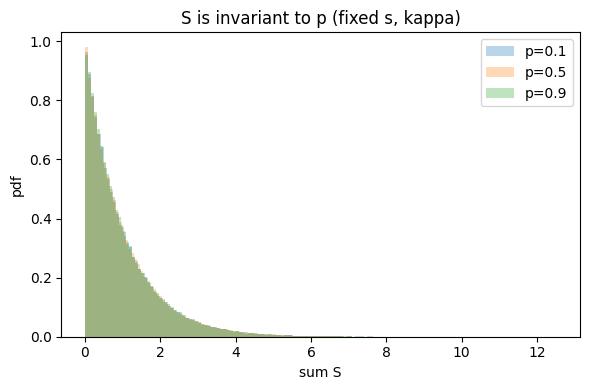

In [14]:
p_list = [0.1, 0.5, 0.9]
s, kappa = 1.0, 1.0
fig, ax = plt.subplots(figsize=(6, 4))
for p in p_list:
    nu_w, nu_e = sample_nu(p, s, kappa, n=200_000)
    S = nu_w + nu_e
    ax.hist(S, bins=150, density=True, alpha=0.3, label=f"p={p}")
ax.set_xlabel("sum S")
ax.set_ylabel("pdf")
ax.set_title("S is invariant to p (fixed s, kappa)")
ax.legend()
plt.tight_layout()
plt.show()


## Effect of $p$ on pitchedness $\pi=\nu_w/S$ (fixed $\kappa$)

Note that for the uninformative case $p=0.5$ this takes the prior form we would like: anticipates EITHER unvoiced or voice but still has mass in between. When $\kappa$ starts to grow this behavior goes away to concentration around $p = 0.5$.


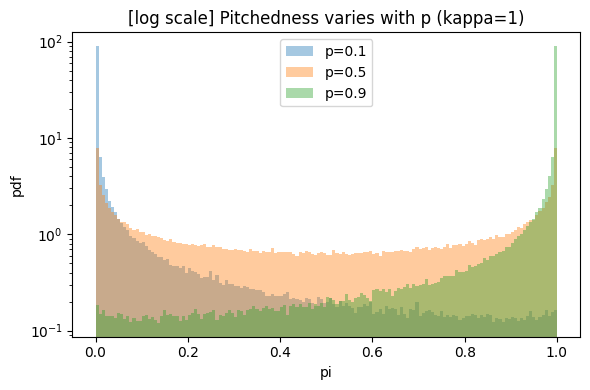

In [19]:
kappa = 1.0
fig, ax = plt.subplots(figsize=(6, 4))
for p in p_list:
    nu_w, nu_e = sample_nu(p, s=1.0, kappa=kappa, n=200_000)
    pi = nu_w / (nu_w + nu_e)
    ax.hist(pi, bins=150, density=True, alpha=0.4, label=f"p={p}")
ax.set_xlabel("pi")
ax.set_ylabel("pdf")
ax.set_title("[log scale] Pitchedness varies with p (kappa=1)")
ax.legend()
ax.set_yscale("log")
plt.tight_layout()
plt.show()


## Effect of $\kappa$ on concentration at fixed means

Means are fixed by $(s,p)$, while $\kappa$ tightens both $S$ and $\pi$.


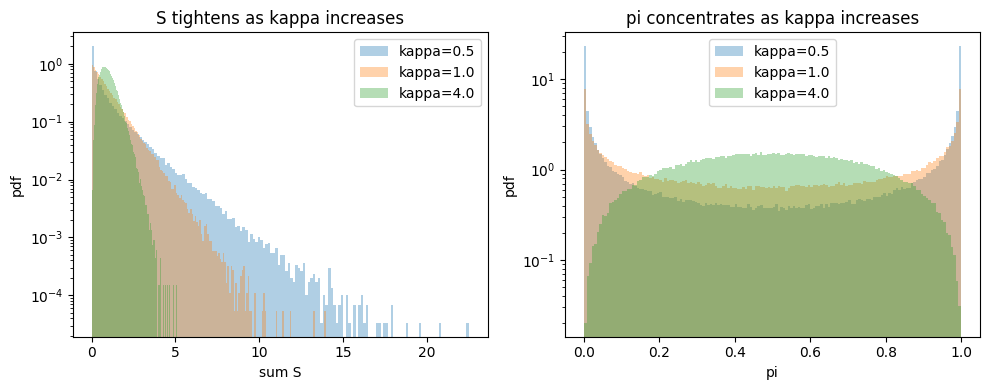

In [20]:
p = 0.5
k_list = [0.5, 1.0, 4.0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for kappa in k_list:
    nu_w, nu_e = sample_nu(p, s=1.0, kappa=kappa, n=200_000)
    S = nu_w + nu_e
    pi = nu_w / S
    axs[0].hist(S, bins=150, density=True, alpha=0.35, label=f"kappa={kappa}")
    axs[1].hist(pi, bins=150, density=True, alpha=0.35, label=f"kappa={kappa}")
axs[0].set_xlabel("sum S")
axs[0].set_ylabel("pdf")
axs[0].set_title("S tightens as kappa increases")
axs[0].legend()
axs[1].set_xlabel("pi")
axs[1].set_ylabel("pdf")
axs[1].set_title("pi concentrates as kappa increases")
axs[1].legend()
axs[0].set_yscale("log")
axs[1].set_yscale("log")
plt.tight_layout()
plt.show()


## Baselines and quick conversions

Defaults here: $s=1,\ p=1/2,\ \kappa=1$. Paper baseline maps to $s=2,\ p=1/2,\ \kappa=2$.


In [7]:
print(
    "Our defaults (p=0.5, s=1, kappa=1):",
    beta_gamma_to_gamma_params(0.5, 1.0, 1.0),
)
print(
    "Paper baseline mapped (p=0.5, s=2, kappa=2):",
    beta_gamma_to_gamma_params(0.5, 2.0, 2.0),
)


Our defaults (p=0.5, s=1, kappa=1): (0.5, 1.0, 0.5, 1.0)
Paper baseline mapped (p=0.5, s=2, kappa=2): (1.0, 1.0, 1.0, 1.0)


## Final notes

- $\kappa$ means how certain are we. $\kappa$ should not be set too high ($>2$) if $p = 0.5$ uninformative as it will judge complete (un)voicedness very unlikely.

- To target a fixed dB mean ratio $r=\mathbb{E}[\nu_e]/\mathbb{E}[\nu_w]$, set $p=1/(1+r)$ (e.g., $r=10^{-2}$ for 20 dB down gives $p\approx 0.9901$).

- Our ad-hoc reparameterization also emerges from a minimum-KL projection of the paper's base prior onto distributions with given $\mathbb{E}[S]$ and $\mathbb{E}[\pi]$ plus a single concentration constraint (which leads to $\kappa$).
